In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tools.train as train
import tools.models as models
import tools.plot as plot

Using TensorFlow backend.


In [2]:
# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


In [3]:
largest_class_count = df["train"].groupby("Classes").size().max()
class_weights = np.divide(largest_class_count, df["train"].groupby("Classes").size().to_numpy())

print("Weighting the classes:", class_weights)

# Make the CNN
nblocks = 5
nfilters = 75
filter_width = 6
batch_size = 50
pool_size = 5
conv_padding = "same"

# Start
layerlist_res = [
    ("conv",
        {
            "filters": int(nfilters),
            "width": int(filter_width),
            "padding": conv_padding,
            "activation": "linear",
        },
    ),
    (layers.BatchNormalization(),),
    (layers.Activation("relu"),),
]

# Residual blocks
for block in range(int(nblocks)):
    layerlist_res.extend(
        [
            ("startskip",),
            ("conv",
                {
                    "filters": int(nfilters),
                    "width": int(filter_width),
                    "padding": conv_padding,
                    "activation": "linear",
                },
            ),
            (layers.BatchNormalization(),),
            (layers.Activation("relu"),),
            ("conv",
                {
                    "filters": int(nfilters),
                    "width": int(filter_width),
                    "padding": conv_padding,
                    "activation": "linear",
                },
            ),
            ("endskip",),
            (layers.BatchNormalization(),),
            (layers.Activation("relu"),),
            ("maxpool", int(pool_size)),
        ]
    )

# End
layerlist_res.extend([
    ("conv",
        {
            "filters": int(nfilters),
            "width": 1,
            "padding": conv_padding,
            "activation": "linear",
        },
    ),
    (layers.BatchNormalization(),),
    (layers.Activation("relu"),),
    (layers.Dropout(0.456),)
])

config = {
    "optimizer": "Nadam",
    "loss": "categorical_crossentropy",
    "class_weights": class_weights,
    "batch_size": int(batch_size),
    "val_split": 0.05,
    "epochs": 500,
    "verbose": 0,
    "patience": 500,
    "progbar": True,
    "regularizer": regularizers.l1_l2(l1=0.00213, l2=0.0549),
}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model_res = models.create_conv1d(inputsize, layerlist_res, ncategories, config)
history = train.train(model_res, inputs, labels, config)

Weighting the classes: [  1.          32.60053981  12.52090532 113.05928237  11.26900949]


Train accuracy: 0.9995203
Test accuracy: 0.98931116


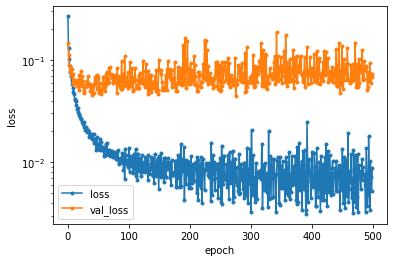

Confusion matrix, without normalization
[[18062    34    14     7     1]
 [   75   469     8     3     1]
 [   29     4  1401    14     0]
 [   18     1    12   131     0]
 [   10     1     1     1  1595]]


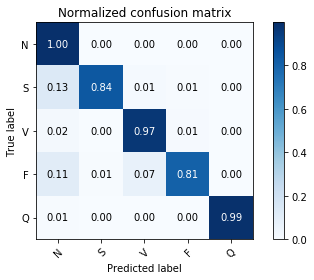

In [4]:
print(
    "Train accuracy:",
    model_res.evaluate(inputs["train"], labels["train"], verbose=0)[1],
)
print(
    "Test accuracy:",
    model_res.evaluate(inputs["test"], labels["test"], verbose=0)[1],
)
plot.plot_fit_history(history)

test_pred = np.argmax(model_res.predict(inputs["test"]), axis=1)
plot.plot_cm(sparse_labels["test"], test_pred, classes=np.array(["N", "S", "V", "F", "Q"]), normalize=True)

Let's save the model with its architecture and weights.

In [5]:
if not os.path.exists(os.path.join("..", "models", rightnow, "nofft")):
    os.makedirs(os.path.join("..", "models", rightnow, "nofft"))
model_res.save(os.path.join("..", "models", rightnow, "nofft", "CNN.h5"))

In [6]:
model_res.summary()

Model: "conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 187, 75)      525         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 75)      300         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 187, 75)      0           batch_normalization[0][0]        
_____________________________________________________________________________________________